# Exploratory Data Analysis - TripAdvisor data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline
pd.set_option('display.max_columns', None)

In [5]:
def handle_duplicate_addresses(df):
    while (df[['address']].duplicated()).any():
        df.loc[df[['address']].duplicated(), 'address'] = df.loc[df[['address']].duplicated(), 'address'] + ','
        print(df.loc[df[['address']].duplicated(), 'address'].tolist())
    return df

df_post = pd.read_csv('cleaned_restaus.csv', index_col=0)
df_post = handle_duplicate_addresses(df_post)


print(len(df_post.loc[df_post[['address']].duplicated(), 'address']))


['100 Cromwell Road, London SW7 4ER England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,', '87-135 Brompton Road, London SW1X 7XL England bis,', '181 Piccadilly Fortnum & Mason, London W1A 1ER England bis,', '9 Conduit Street, London W1S 2XG England bis,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,', '16 Carlos Place Mayfair, London W1K 2AL England bis,', '1 Kensington Court The Milestone Hotel, London W8 5DL England bis,']
['87-135 Brompton Road, London SW1X 7XL England bis,,', '87-135 Brompton Road, London SW1X 7XL England bis,,', '87-135 Brompton Road, London SW1X 7XL England bis,,', '1 Hamilton Place Park Lane, London W1J 7QY England bis,,']
['87-135 Brompton Road, London SW1X 7XL England bis,,,', '87-135 Brompton Road, London SW1X 7XL England bis,,,']
['87-135 Brompton Road, London SW1X 7X

In [39]:
df_post.to_csv('cleaned_restaus2.csv')

# Preprocessing

In [52]:
def freq_dict_generator(keywords, keywords_dict):
    """Creation of a dict containing all of the keywords. """
    for keyword in keywords:
        if keyword not in keywords_dict:
            keywords_dict[keyword] = 1
        else:
            keywords_dict[keyword] += 1

def col_evaluation(ls, col_name):
    """ Function used to check if a given cuisine is present in the list of the 'cuisine' column. It is
    used in a parallelised manner."""
    if col_name in ls:
        val = 1
    else:
        val = 0
    return val
            
def generate_cuisine_cols(df, cuisine_dict):
    """ Creation of the columns containing all of the cuisine types in a dataframe. """
    for col_name in cuisine_dict:
        df[col_name] = df['cuisine'].apply(lambda x: col_evaluation(x, col_name))
    return df

def keywords_list_parser(ls):
    """Parses a given list of 3 keywords to determine the main cuisine (ex: Indian, British), the food specificity 
    (Vegan, serving seafood...) and whether the restaurant has unique features (ex: if it is a bar, a pub...). Each
     keyword is read in order to first find the specificity and the feature. For the cuisine, the algorithm first
     tries to find a 'tier one cuisine' (i.e a very specific type of cuisine) before moving on to a 'tier two cuisine' 
     (i.e a more global type of cuisine such as 'European'). For each category, a hardcoded list of entries is read. """
    
    place_type = None
    food_spec = None
    cuisine_t1 = None
    cuisine_t2 = None

    found_place = False
    found_spec = False
    found_cuisine_t1 = False
    found_cuisine_t2 = False

    place_type_ls = ['Bar', 'Pub', 'Cafe', 'Street food', 'Steakhouse']

    food_specifity = ['Vegan', 'Gluten Free Options', 'Healthy', 'Fast food', 'Barbecue', 'Seafood',
                      'Fusion', 'Contemporary', 'Halal']
    
    cuisine_tier_one = ['British', 'French', 'Italian', 'Indian', 'Spanish', 'Turkish',
                        'South American', 'Other European', 'Lebanese', 'Moroccan', 'American',
                        'Thai', 'African'] 

    cuisine_tier_two = ['Asian', 'European', 'Other European', 'Middle Eastern', 'International']
    
    for word in ls:
        
        if (word in place_type_ls) and (found_place == False):
            place_type = word
            found_place = True
        if (word in food_specifity) and (found_spec == False):
            food_spec = word
            found_spec = True
        if (word in cuisine_tier_one) and (found_cuisine_t1 == False):
            cuisine_t1 = word
            found_cuisine_t1 = True
        if (word in cuisine_tier_two) and (found_cuisine_t2 == False):
            cuisine_t2 = word
            found_cuisine_t2 = True
        
    if cuisine_t1 == None:
        cuisine = cuisine_t2
    else:
        cuisine = cuisine_t1
            
    return [cuisine, food_spec, place_type]
    

def simplify_keywords(keyword_ls, keyword_dict):
    """Simplifies keywords thanks to a hardcoded dict given as input. It is used to assemble close cuisines and 
    features into a single entry to enhance the analysis (ex : Sri Lankan and Indian are grouped)."""
    new_keyword_ls = [keyword_dict.get(item,item) for item in keyword_ls]
    return new_keyword_ls
    
def score_builder(text):
    """A unified ranking score is built by considering this formula : 
    
    score = (total_entries - rank + 1)/total_entries
    
    Therefore, restaurants ranking can be compared across different locations. """
    
    if text != 'Ranking not found':
        rank = int(text[1])
        total_entries = int(text.split()[2].replace(',',''))
        score = (total_entries - rank + 1) / total_entries
        return round(score, 3)
    else:
        return None
    
def location_extractor(text):
    """Used to extract the neighborhood where the restaurant is located."""
    if text != 'Ranking not found':
        return text.split()[-1]
    else:
        return None

def identify_coordinates(address, postcode=False):
    """This functions performs an API call with the scrapped address of the restaurant to the OpenStreetMap API.
    A longitude and a latitude are then returned."""
    
    if postcode:
        postcode = get_postcode(address)
        if postcode == None:
            return (None, None, False)
        target_url = 'https://nominatim.openstreetmap.org/search?q=' + postcode + '&format=json'
    else:
        target_url = 'https://nominatim.openstreetmap.org/search?q=' + address + '&format=json'
        
    target_url = target_url.replace(',', '%2C')
    target_url = target_url.replace(' ', '+')

    r = requests.get(target_url)
    found_coordinates = True
    if r.status_code==200:
        try:
            coordinates = r.json()[0]
            latitude, longitude = coordinates['lat'], coordinates['lon']
            
        except:
            #print(f'Address not found for: {target_url}')
            latitude, longitude = None, None
            found_coordinates = False
            
    else:
        print(f'Error {status_code} ocurred on the request')
        latitude, longitude, found_coordinates = None, None, False
    return latitude, longitude, found_coordinates 
    
def get_postcode(address):
    f = lambda x, y: x+' '+y
    splits = address.split(' ')
    splits_lagged = splits[1:] + ['']
    total_splits = set(map(f, splits, splits_lagged))
    postcode_ls = [split for split in total_splits if (split.upper() == split) and (len(split)>=7 and len(split)<=9)]
    if postcode_ls == []:
        postcode = None
    else:
        postcode = postcode_ls[0]
    return postcode

def haversine_dist_to_bokan(lat, lon):
    """Computes the Haversine distance of a given restaurant to the Bokan, given a longitude and a latitude."""

    deg_to_rad = lambda x: x * np.pi/180
    
    bokan_lat = 51.501244
    bokan_lon = -0.023363
    
    R = 6371 # Radius of the earth in km
    deg_lat = deg_to_rad(lat - bokan_lat)
    deg_lon = deg_to_rad(lon - bokan_lon) 
    a = np.sin(deg_lat/2) * np.sin(deg_lat/2) + np.cos(deg_to_rad(lat)) * np.cos(deg_to_rad(bokan_lat)) * np.sin(deg_lon/2) * np.sin(deg_lon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c ## Distance in km
    return np.round(d, 3)

def process_distances(df, print_output=100):
    """Determines all of the distances between the restaurants and the bokan. It also returns the number of 
    restaurants which address couldn't be used to find the latitude and the longitude."""
    adress_list = df['address'].tolist()
    not_found_counter = 0
    for counter, address in enumerate(adress_list):
        lat, lon, found_coordinates = identify_coordinates(address)
        if found_coordinates == False:
            lat, lon, found_coordinates = identify_coordinates(address, postcode=True)
            if found_coordinates == False:  
                not_found_counter += 1
        if counter%print_output == 0:
            print(f'{counter}/{len(df)} restaurant coordinates have been processed.')
        adress_list[counter] = [lat, lon]
    print(f'Finished determining coordinates. {not_found_counter}/{len(df)} coordinates have not been found.')
    
    np_coords = np.asarray(adress_list, dtype=np.float32)
    np_lat, np_lon = np_coords[:,0], np_coords[:,1]
    distances = haversine_dist_to_bokan(np_lat, np_lon)

    return distances

def handle_duplicate_addresses(df):
    while (df[['address']].duplicated()).any():
        df.loc[df[['address']].duplicated(), 'address'] = df.loc[df[['address']].duplicated(), 'address'] + ','
    return df
    

def cleaning_pipeline(df, keywords_renaming_dict, parse_distances=False):
    """Performs all of the cleaning operations. The process_distances parameter is set on False by default as the 
    number of API calls can run for a substantial amount of time."""
    cuisine_dict = {}
    df_restaurants_cuisine = df.copy()
    df_restaurants_cuisine = df_restaurants_cuisine.rename(columns={'cuisine':'keywords'})                                                                                   
    # Creates a frequency dictionary containing the occurence of all types of cuisine
    df_restaurants_cuisine['keywords'].apply(lambda x: freq_dict_generator(x, cuisine_dict))
    
    # Converting reviews as int
    df_restaurants_cuisine['nb_reviews'] = df_restaurants_cuisine['nb_reviews'].str.replace(',','').astype('int64')
    
    # Creates a ranking score in order to compare restaurants competing among a different amount of restaurants
    # in a neighborhood. The score of the restaurant ranked i among n restaurants is as such : 
    # Score = (n - i + 1) / n
    df_restaurants_cuisine['score'] = df_restaurants_cuisine['ranking'].apply(lambda x: score_builder(x))
    
    # Extracts the neighborhood where the restaurant is located
    df_restaurants_cuisine['neighborhood'] = df_restaurants_cuisine['ranking'].apply(lambda x: location_extractor(x))
    
    # Simplifies and groups the original keywords to enhance the analysis
    df_restaurants_cuisine['keywords'] = df_restaurants_cuisine['keywords'].apply(lambda x: simplify_keywords(x, 
                                                                                            keywords_renaming_dict))
    
    # Separates the keywords into useful categories used to performed detailled analysis
    df_restaurants_cuisine['cuisine'] = None
    df_restaurants_cuisine['food_specificity'] = None
    df_restaurants_cuisine['place_type'] = None
    key_res = df_restaurants_cuisine['keywords'].apply(keywords_list_parser)
    df_restaurants_cuisine[['cuisine','food_specificity','place_type']] = pd.DataFrame(key_res.tolist(), index=df_restaurants_cuisine.index)
    
    
    # Computes the distance in kilometers between the Bokan and the scrapped restaurant
    if parse_distances:
        df_restaurants_cuisine['distance_to_bokan'] = process_distances(df_restaurants_cuisine)
    
    df_restaurants_cuisine = handle_duplicate_addresses(df_restaurants_cuisine)
    # Used to generate the columns indicating the cuisine of the restaurant - DEPRECATED
    #df_restaurants_cuisine = generate_cuisine_cols(df_restaurants_cuisine, cuisine_dict)
    
    return df_restaurants_cuisine, cuisine_dict

def cuisine_stats(df, target_col='cuisine', stats='mean', 
                  cols=['cuisine', 'nb_reviews', 'min_price', 'max_price', 'rating', 'score', 'neighborhood']):
    """ Generate statistics on restaurants, using a column such as the type of cuisine or the special features. """
    df_res = df[cols].groupby(by=target_col)
    temp = df_res.size()
    if stats == 'mean':
        df_res = df_res.mean()
        rename_dict = {col:'mean_' + col for col in df_res.columns}
    elif stats == 'median':
        df_res = df_res.median()
        rename_dict = {col:'median_' + col for col in df_res.columns}
    elif stats == 'std':
        df_res = df_res.std()
        rename_dict = {col:'std_' + col for col in df_res.columns}
    df_res = df_res.rename(columns=rename_dict)
    df_res['nb_restaus'] = temp.tolist()
    cols = df_res.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_res = df_res[cols]
#     f = lambda x: cuisine_name if x==1 else 'Other cuisines'
#     df_res.index = list(map(f, df_res.index))
    return df_res

In [23]:
root_path = os.path.join('../../', 'scraper', 'scraped_data', 'merged_data')

# restaurants_path = os.path.join(root_path, 'merged_restaurants.json')
restaurants_path = os.path.join('../../', 'scraper', 'scraper_restaurants', 'scraped_data', 'restaurants', 'restaurants_run_1.json')
review_path = os.path.join(root_path, 'merged_reviews.json')
users_path = os.path.join(root_path, 'merged_users.json')

df_restaurants = pd.read_json(restaurants_path, lines=True)
restaurants = list(df_restaurants['restaurant_id'])
df_restaurants = df_restaurants.set_index('restaurant_id')

df_reviews = pd.read_json(review_path, lines=True)
df_users = pd.read_json(users_path, lines=True)


In [24]:
df_restaurants.head()

,name,resto_TA_url,nb_reviews,min_price,max_price,cuisine,address,phone_number,website,menu,ranking,rating
restaurant_id,,,,,,,,,,,,
1,Taste Of Peshawar,https://www.tripadvisor.co.uk/Restaurant_Revie...,171,2.0,3.0,"[Grill, Pakistani, Afghani]","62 Harrow Road, Wembley HA9 6PL England",+44 20 3015 4133,Website not scraped,Menu not scraped,#1 of 155 Restaurants in Wembley,5.0
16,Orpington Citi Kitchen,https://www.tripadvisor.co.uk/Restaurant_Revie...,146,2.0,3.0,"[Indian, Asian, Vegetarian Friendly]","82 Cotmandene Crescent, Orpington, Bromley BR5...",+44 20 8302 2222,Website not scraped,Menu not scraped,#2 of 117 Restaurants in Orpington,5.0
19,4 Locos Argentine Steakhouse,https://www.tripadvisor.co.uk/Restaurant_Revie...,139,2.0,3.0,"[Steakhouse, Argentinian, Vegetarian Friendly]","6-8 Tudor Court- Russell Hill Road, Purley CR8...",+44 20 8660 5200,Website not scraped,Menu not scraped,#1 of 32 Restaurants in Purley,5.0
17,La Plata Steakhouse,https://www.tripadvisor.co.uk/Restaurant_Revie...,221,2.0,3.0,"[Steakhouse, Latin, Argentinian]","East Sheen 109 Sheen Lane, Richmond SW14 8AE E...",+44 20 8876 7747,Website not scraped,Menu not scraped,#1 of 116 Restaurants in Richmond,5.0
22,Madhu's Heathrow,https://www.tripadvisor.co.uk/Restaurant_Revie...,637,2.0,3.0,"[Indian, Asian, Vegetarian Friendly]",Bath Road Sheraton Skyline Hotel London Heathr...,+44 20 8564 3380,Website not scraped,Menu not scraped,Ranking not found,4.5


In [35]:
keywords_renaming_dict = {
    'Southern-Italian':'Italian', 'Sicilian':'Italian', 'Tuscan':'Italian', 'Neapolitan':'Italian',
    'Central-Italian':'Italian', 'Pizza':'Italian', 'Polish':'European', 'Belgian':'European',
    'German':'European', 'Eastern European':'European', 'Portuguese':'European',
    'Greek':'European', 'Hong Kong':'Chinese','Cantonese':'Chinese', 'Sushi':'Japanese', 
    'Malaysian':'Asian', 'Tibetan':'Asian', 'Vietnamese':'Asian', 'Latin':'South American', 
    'Argentinian':'South American', 'Mexican':'South American', 'Brazilian':'South American',
    'Colombian':'South American', 'Vegetarian Friendly':'Vegan', 'Vegan Options':'Vegan', 'Persian':'Middle Eastern',
    'Afghani':'Middle Eastern', 'Deli':'Indian', 'Sri Lankan':'Indian', 'Pakistani':'Indian', 'Balti':'Indian',
    'Nepalese':'Indian', 'Jamaican':'African', 'Carribean':'African', 'Cajun & Creole':'African',
    'Moroccan':'African', 'Brew Pub':'Pub', 'Gastropub':'Pub', 'Grill':'Barbecue'}

df_restaurants_cuisine, cuisine_dict = cleaning_pipeline(df_restaurants, keywords_renaming_dict, parse_distances=True)

restaurant_id
1                        [Grill, Pakistani, Afghani]
16              [Indian, Asian, Vegetarian Friendly]
19    [Steakhouse, Argentinian, Vegetarian Friendly]
17                  [Steakhouse, Latin, Argentinian]
22              [Indian, Asian, Vegetarian Friendly]
Name: keywords, dtype: object
['Grill', 'Pakistani', 'Afghani']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Steakhouse', 'Argentinian', 'Vegetarian Friendly']
<class 'list'>
['Steakhouse', 'Latin', 'Argentinian']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'Pizza', 'British']
<class 'list'>
['Italian', 'Deli', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Grill']
<class 'list'>
['Lebanese', 'Cafe', 'Mediterranean']
<class 'list'>
['Mediterranean', 'European', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Lebanese', 'Mediterranean', 'Spani

<class 'list'>
['Caribbean', 'Jamaican', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Asian', 'Malaysian']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Asian', 'Thai']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Italian', 'Mediterranean', 'British']
<class 'list'>
['British']
<class 'list'>
['Indian', 'Asian', 'Grill']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['British', 'Vegetarian Friendly', 'Gluten Free Options']
<class 'list'>
['Mediterranean', 'Turkish', 'Vegetarian Friendly']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Mediterranean', 'European']
<class 'list'>
['International', 'Gluten Free Options']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Bar', 'European', 'Pub']
<class 'list'>
['Bar', 'British

['Indian', 'Asian', 'Bangladeshi']
<class 'list'>
['Chinese', 'Asian', 'Cantonese']
<class 'list'>
['Italian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['European', 'Portuguese', 'Vegetarian Friendly']
<class 'list'>
['Brazilian', 'Barbecue', 'Argentinian']
<class 'list'>
['Indian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Turkish', 'Vegetarian Friendly', 'Halal']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Steakhouse', 'Bar', 'Pub']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Middle Eastern', 'Arabic', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Cafe', 'Grill', 'Healthy']
<class 'list'>
['Lebanese', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Lebanese', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['Italian', 'Pizza', 'European']
<class 'list'>
['Indian', 'Vegetarian Friendly', '

['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Vegetarian Friendly']
<class 'list'>
['Middle Eastern', 'Persian', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'Turkish', 'Middle Eastern']
<class 'list'>
['Cafe', 'British', 'Diner']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Indian', 'Asian', 'Fusion']
<class 'list'>
['Fast food', 'British']
<class 'list'>
['Asian', 'Vietnamese']
<class 'list'>
['Eastern European', 'Ukrainian']
<class 'list'>
['Mexican', 'Peruvian', 'Healthy']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Cafe', 'European', 'Vegan Options']
<class 'list'>
['French', 'European', 'Wine Bar']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Cafe',

<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Mediterranean', 'Middle Eastern', 'Persian']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'Pub']
<class 'list'>
['Cafe', 'International', 'British']
<class 'list'>
['British']
<class 'list'>
['Pizza', 'Fast food', 'Vegan Options']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Middle Eastern']
<class 'list'>
['Chinese', 'Asian']
<class 'list'>
['Portuguese']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Seafood', 'Fast food', 'British']
<class 'list'>
['Quick Bites', 'Bar', 'British']
<class 'list'>
['Italian', 'Indian', 'Cafe']
<class 'list'>
['Chinese']
<class 'list'>
['Chinese', 'Asian', 'Thai']
<class 'list'>
[]
<class 'list'>
['Fast food', 'Middle Eastern', 'Halal']
<class 'list'>
['Cafe']
<class 'list'>
['Indian', 'Asian']
<class 'list'>
['Italian', 'C

['Turkish']
<class 'list'>
['Indian']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Fast food']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Bar', 'Pub']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Chinese']
<class 'list'>
['Indian']
<class 'list'>
['Italian', 'Cafe', 'European']
<class 'list'>
[]
<class 'list'>
['Bar']
<class 'list'>
[]
<class 'list'>
['Quick Bites', 'Seafood', 'Fast food']
<class 'list'>
['Quick Bites', 'American', 'Fast food']
<class 'list'>
['Cafe', 'International', 'Vegetarian Friendly']
<class 'list'>
['Caribbean', 'Grill', 'Jamaican']
<class 'list'>
['British']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Cafe']
<class 'list'>
['Quick Bites', 'Bar', 'British']
<class 'list'>
['Fast food', 'South American']
<class 'list'>
['Cafe', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['Ge

['Pizza']
<class 'list'>
[]
<class 'list'>
['Brew Pub', 'Pub', 'Street Food']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Indian']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Chinese', 'Asian', 'Thai']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Pizza', 'Fast food']
<class 'list'>
['British']
<class 'list'>
['British']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Italian', 'French', 'Spanish']
<class 'list'>
['Indian', 'Fast food', 'Halal']
<class 'list'>
['Caribbean', 'Seafood']
<class 'list'>
['Caribbean']
<class 'list'>
['Thai']
<class 'list'>
['Turkish']
<class 'list'>
[]
<class 'list'>
['European', 'Eastern European', 'Romanian']
<class 'list'>
[]
<class 'list'>
['Fast food', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Cafe', 'British']
<class 'list'>
['Indian']
<class 'list'>
['P

['Indian', 'Thai']
<class 'list'>
['Mediterranean', 'Greek', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Bar', 'British', 'Grill']
<class 'list'>
['Chinese']
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Middle Eastern', 'Pakistani']
<class 'list'>
['Mediterranean', 'Turkish', 'Greek', 'Grill']
<class 'list'>
['British']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['American']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
[]
<class 'list'>
['Healthy']
<class 'list'>
['Italian', 'Cafe', 'European']
<class 'list'>
['Armenian']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Lebanese', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Mediterranean', 'European']
<class 'list'>
[]
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Irish', 'Bar', 'British']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Italian', '

<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Chinese']
<class 'list'>
['British']
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Seafood']
<class 'list'>
['Italian', 'Mediterranean', 'Vegetarian Friendly']
<class 'list'>
['Fast food']
<class 'list'>
['Chinese']
<class 'list'>
['French', 'Cafe', 'European']
<class 'list'>
['Mexican', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Indian', 'Asian']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['British', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Mediterranean', 'European', 'Spanish']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'European', 'Spanish']
<class 'list'>
['French', 'American', 'British']
<class 'list'>
['Indian', 'Fast food']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'European', 'Contemporary']
<class 'list'

['Bar', 'British', 'Pub']
<class 'list'>
[]
<class 'list'>
['Pizza']
<class 'list'>
['Philippine', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'European', 'Turkish']
<class 'list'>
['Deli']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Steakhouse', 'Seafood', 'Vegetarian Friendly']
<class 'list'>
['American', 'British', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'British']
<class 'list'>
['Italian', 'Steakhouse', 'Mediterranean']
<class 'list'>
['Mexican', 'Latin', 'Bar']
<class 'list'>
['British', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Sushi']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Grill']
<class 'list'>
['European', 'South American', 'Colombian']
<class 'list'>
['British', 'Pub', 'Vegetarian Friendly']
<class 'list'>
['British', 'Grill', 'Contemporary']
<class 'list'>
[]
<class 'list'>
['Asian', 'Taiwanese']
<class 'list'>
['Healthy']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Italian', 'P

['Bar', 'British', 'Pub']
<class 'list'>
['Cafe', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Italian', 'European', 'Vegetarian Friendly']
<class 'list'>
['Lebanese', 'Moroccan', 'International']
<class 'list'>
['Mediterranean', 'European', 'Greek']
<class 'list'>
['Fast food']
<class 'list'>
['Italian', 'Pizza']
<class 'list'>
['British', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Pizza']
<class 'list'>
['Cafe', 'Asian', 'Malaysian']
<class 'list'>
['Italian', 'Vegetarian Friendly', 'Gluten Free Options']
<class 'list'>
['Steakhouse', 'European', 'British']
<class 'list'>
['Quick Bites', 'Cafe', 'Contemporary']
<class 'list'>
['American', 'British', 'Vegetarian Friendly']
<class 'list'>
['Healthy']
<class 'list'>
['Bar', 'European', 'Contemporary']
<class 'list'>
['Polish', 'European']
<class 'list'>
['Fast food']
<class 'list'>
['Mexican']
<class 'list'>
['British', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Italian', 'Mediterranean', 'Neapoli

['Pizza']
<class 'list'>
['Pizza']
<class 'list'>
['American', 'Bar', 'Barbecue']
<class 'list'>
['Steakhouse', 'British', 'Gluten Free Options']
<class 'list'>
['French', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Japanese']
<class 'list'>
['Italian']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']
<class 'list'>
['Indian', 'Grill', 'Bangladeshi']
<class 'list'>
['Mexican']
<class 'list'>
['Cafe', 'British', 'Healthy']
<class 'list'>
['Cafe', 'Vegetarian Friendly']
<class 'list'>
['French', 'Bar', 'British']
<class 'list'>
[]
<class 'list'>
['Indian', 'Asian', 'Pakistani']
<class 'list'>
[]
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'Asian', 'Pub']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Fast food', 'Vegetarian Friendly']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['German', 'Middle Eastern']
<class 'list'>


<class 'list'>
['Italian', 'Chinese', 'Moroccan']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Indian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
[]
<class 'list'>
['American', 'Bar', 'Fast food']
<class 'list'>
['Vegan Options', 'Gluten Free Options']
<class 'list'>
[]
<class 'list'>
['Mexican', 'Fast food', 'South American']
<class 'list'>
[]
<class 'list'>
['Italian', 'Pizza', 'European']
<class 'list'>
['Quick Bites', 'Bar', 'British']
<class 'list'>
[]
<class 'list'>
['Cafe', 'British']
<class 'list'>
['Japanese', 'Sushi']
<class 'list'>
['Seafood', 'British', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'Turkish', 'Middle Eastern']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['French', 'Cafe']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Grill']
<class 'list'>
['Bar', 'British', 'Wine Bar']
<class 'list'>
['Fusion', 'Vegetarian Friendly', 'Kosher']
<class 'list'>
['Cafe', 

['Bar', 'British', 'Pub']
<class 'list'>
['Japanese', 'Asian', 'Korean']
<class 'list'>
['Bar', 'European', 'British']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Fast food', 'Vegetarian Friendly']
<class 'list'>
['Italian']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Japanese', 'Seafood', 'Sushi']
<class 'list'>
['American', 'Fusion']
<class 'list'>
['British', 'Pub', 'Gastropub']
<class 'list'>
['Italian', 'Cafe', 'Fast food']
<class 'list'>
['Italian', 'Mediterranean', 'European']
<class 'list'>
['Fast food', 'European', 'Healthy', 'Scandinavian']
<class 'list'>
['International']
<class 'list'>
['Deli', 'Vegetarian Friendly']
<class 'list'>
['Japanese', 'American', 'Japanese Fusion']
<class 'list'>
['Indian']
<class 'list'>
['Cafe']
<class 'list'>
['Japanese', 'Fast food', 'Sushi']
<class 'list'>
[]
<class 'list'>
['Briti

<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['British']
<class 'list'>
['Mediterranean']
<class 'list'>
['American', 'Fast food']
<class 'list'>
['American', 'Fast food']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Indian']
<class 'list'>
['Turkish']
<class 'list'>
[]
<class 'list'>
['Chinese']
<class 'list'>
['Pizza']
<class 'list'>
[]
<class 'list'>
['European', 'Central European']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Indian']
<class 'list'>
[]
<class 'list'>
['Greek', 'Grill', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Turkish']
<class 'list'>
[]
<class 'list'>
['European', 'Romanian']
<class 'list'>
[]
<class 'list'>
['Asian', 'Sri Lankan']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Seafood']
<class 'list'>
['Chinese']
<class 'list'>
['European', 'British', 'Scandinavian']
<class 'list'>
[]
<class 'list'>
['Indian']
<class 'list'>
[]
<cl

<class 'list'>
['American', 'British', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Asian']
<class 'list'>
['Bar', 'International', 'British']
<class 'list'>
['Fast food']
<class 'list'>
['Cafe']
<class 'list'>
['American', 'Grill', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'European', 'British']
<class 'list'>
['British']
<class 'list'>
['Lebanese', 'Fast food', 'Mediterranean']
<class 'list'>
[]
<class 'list'>
['Mediterranean', 'British', 'Grill']
<class 'list'>
[]
<class 'list'>
['Mediterranean', 'European', 'Spanish']
<class 'list'>
['French', 'Steakhouse', 'European']
<class 'list'>
['British']
<class 'list'>
['Italian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Italian', 'Seafood', 'Mediterranean']
<class 'list'>
['Chinese']
<class 'list'>
['European', 'Spanish', 'British']
<class 'list'>
['Fast food']
<class 'list'>
['French', 'Cafe']

['International', 'European', 'British']
<class 'list'>
['Italian', 'Pizza', 'European']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['American', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Italian', 'Mediterranean', 'European']
<class 'list'>
['Bar', 'British', 'Contemporary']
<class 'list'>
['Italian']
<class 'list'>
['Lebanese', 'Mediterranean', 'Middle Eastern']
<class 'list'>
['Bar', 'British', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
[]
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Cafe']
<class 'list'>
['Indian', 'Asian', 'Grill']
<class 'list'>
['Chinese', 'Asian', 'Hong Kong']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Cafe', 'Mediterranean', 'Greek']
<class 'list'>
['Chinese', 'Asian', 'Cantonese']
<class 'list'>
['French']
<class 'list'>
['British', 'Vegetarian Friendly', 'Vegan Options']
<cla

<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Latin', 'Barbecue', 'Spanish']
<class 'list'>
['Chinese', 'Asian', 'Halal']
<class 'list'>
['European', 'Fusion', 'Vegetarian Friendly']
<class 'list'>
['Pizza']
<class 'list'>
[]
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Asian', 'Cantonese']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['European', 'British']
<class 'list'>
['African', 'Vegetarian Friendly']
<class 'list'>
['British']
<class 'list'>
['American', 'Barbecue', 'Halal']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Pizza', 'Halal']
<class 'list'>
['Fast food', 'European', 'Healthy', 'Scandinavian']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['Thai', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
[

<class 'list'>
['Chinese', 'Cantonese']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Pizza']
<class 'list'>
['American', 'Fast food', 'British']
<class 'list'>
['Pub', 'Vegetarian Friendly', 'Gluten Free Options']
<class 'list'>
['Vegetarian Friendly']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Asian', 'Vietnamese']
<class 'list'>
['Italian', 'British', 'Contemporary']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Bar', 'British', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Dessert']
<class 'list'>
['Indian']
<class 'list'>
['Italian', 'Pizza', 'European']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Fast food', 'Vegetarian Friendly']
<class 'list'>
['Lebanese', 'Mediter

['Lebanese', 'Mediterranean', 'Asian']
<class 'list'>
['Indian', 'Asian', 'Middle Eastern']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Pub']
<class 'list'>
[]
<class 'list'>
['British']
<class 'list'>
['Thai']
<class 'list'>
['Steakhouse', 'Gluten Free Options']
<class 'list'>
[]
<class 'list'>
['American', 'Pizza', 'Fast food']
<class 'list'>
['Middle Eastern', 'Persian', 'Vegetarian Friendly']
<class 'list'>
[]
<class 'list'>
['British', 'Vegetarian Friendly', 'Gluten Free Options']
<class 'list'>
['Fast food']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Quick Bites', 'Bar', 'British']
<class 'list'>
[]
<class 'list'>
[]
<class 'list'>
['Chinese']
<class 'list'>
[]
<class 'list'>
['Chinese', 'Asian', 'Cantonese']
<class 'list'>
[]
<class 'list'>
['American', 'Steakhouse', 'Halal']
<class 'list'>
[]
<class 'list'>
['American', 'Barbecue', 'British']
<class 'list'>
['American']
<class 'list'>
['British', 'Grill', 'Contemporary']
<class 'list'>
['Caribbean']
<class 'l

['European', 'Portuguese']
<class 'list'>
['Chinese']
<class 'list'>
['Fast food', 'Turkish', 'Halal']
<class 'list'>
[]
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Seafood', 'Fast food']
<class 'list'>
[]
<class 'list'>
['Mediterranean', 'Middle Eastern', 'Vegetarian Friendly']
<class 'list'>
['Pizza']
<class 'list'>
[]
<class 'list'>
['Pizza']
<class 'list'>
[]
<class 'list'>
['Turkish']
<class 'list'>
['Belgian', 'European']
<class 'list'>
['Indian', 'Bar', 'International']
<class 'list'>
[]
<class 'list'>
['Bar', 'Mediterranean', 'British']
<class 'list'>
['Turkish', 'Middle Eastern']
<class 'list'>
['Seafood', 'Mediterranean', 'European']
<class 'list'>
['Indian']
<class 'list'>
['Grill']
<class 'list'>
['Caribbean']
<class 'list'>
['Fast food', 'Halal']
<class 'list'>
['Lebanese', 'Mediterranean', 'Grill']
<class 'list'>
['International']
<class 'list'>
['Pizza', 'Fast food']
<class 'list'>
['Indian', 'Asian', 'Healthy']
<class 'list'>
[]
<class 'list'>
['British

['Mediterranean']
<class 'list'>
['Middle Eastern', 'Afghani']
<class 'list'>
['Indian']
<class 'list'>
['Cafe', 'Fast food', 'British', 'Diner']
<class 'list'>
[]
<class 'list'>
['Chinese']
<class 'list'>
['British']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Asian', 'Cantonese']
<class 'list'>
['Asian', 'Middle Eastern', 'Pakistani']
<class 'list'>
['Fast food', 'British']
<class 'list'>
['British']
<class 'list'>
[]
<class 'list'>
['South American', 'Colombian']
<class 'list'>
['Cafe']
<class 'list'>
['Pizza', 'Contemporary']
<class 'list'>
['Indian', 'Asian', 'Fusion']
<class 'list'>
['Indian', 'Halal']
<class 'list'>
['Indian']
<class 'list'>
['European', 'British', 'Contemporary']
<class 'list'>
['Mediterranean', 'Japanese Fusion', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Grill']
<class 'list'>
['Cafe']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
[

['Pizza']
<class 'list'>
['Lebanese', 'Fast food', 'Barbecue']
<class 'list'>
['Seafood', 'Fast food']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Indian']
<class 'list'>
[]
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'Pizza', 'Cafe']
<class 'list'>
['Japanese', 'Fast food', 'Asian']
<class 'list'>
['Cafe', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Chinese', 'Asian']
<class 'list'>
['Indian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['British']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Middle Eastern', 'Persian', 'Afghani']
<class 'list'>
['Chinese', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'Contemporary']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Cafe', 'British', 'Deli']
<class 'list'>
['Cafe', 'Vegetarian Friendly']
<class 'list'>
['Cafe']
<class 'list'>
['Bar', 'Bri

['Indian']
<class 'list'>
['Seafood', 'Gluten Free Options']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Chinese', 'Philippine', 'Cafe']
<class 'list'>
['Cafe']
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Middle Eastern', 'Persian', 'Halal']
<class 'list'>
['Bar', 'Pub']
<class 'list'>
['Indian', 'Asian', 'Bangladeshi']
<class 'list'>
['Italian', 'French', 'Mediterranean']
<class 'list'>
['Japanese', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Seafood', 'Fast food']
<class 'list'>
['Fast food', 'Turkish', 'Vegetarian Friendly']
<class 'list'>
['European', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['American', 'Cafe', 'Vegetarian Friendly']
<class 'list'>
['Fast food', 'Turkish', 'Middle Eastern']
<class 'list'>
[]
<class 'list'>
['Seafood', 'Mediterranean', 'Greek']
<class 'list'>
['Mediterranean', 'British']
<class 'list'>
['American', 'Seafood', 'Gluten Free Options']
<class 'list'>
['Indian', 'British',

<class 'list'>
['Steakhouse', 'Seafood', 'European']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['European', 'British', 'Grill']
<class 'list'>
['Cafe', 'Mediterranean', 'Deli']
<class 'list'>
['Indian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Cafe', 'British', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['British']
<class 'list'>
['Mediterranean', 'Turkish', 'Healthy']
<class 'list'>
[]
<class 'list'>
['Bar', 'European', 'British']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Mexican', 'American', 'Bar']
<class 'list'>
['British', 'Pub', 'Gastropub']
<class 'list'>
['Indian', 'Vegetarian Friendly']
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Quick Bites', 'Bar', 'British']
<clas

['Japanese', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Caribbean', 'Fast food', 'International']
<class 'list'>
['Indian', 'Bar', 'Asian']
<class 'list'>
['Vegetarian Friendly', 'Gluten Free Options']
<class 'list'>
['Cafe', 'Middle Eastern', 'Persian']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Dessert', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Indian', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['American', 'Gluten Free Options']
<class 'list'>
['French', 'European', 'British']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Pub']
<class 'list'>
['Lebanese', 'Mediterranean', 'Grill']
<class 'list'>
['Brew Pub', 'British', 'Vegetarian Friendly']
<class 'list'>
['Steakhouse', 'European', 'British']
<class 'list'>
['Asian', 'Sri Lankan', 'Vegetarian Friendly']
<class 'list'>
['Seafood']
<class 'list'>
['Italian', 'European', 'Vegetarian Friendly']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['In

<class 'list'>
['Japanese', 'Asian', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Chinese', 'Indian', 'Bar']
<class 'list'>
['Italian', 'Pizza', 'Vegetarian Friendly']
<class 'list'>
['Mediterranean', 'European', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Bar', 'Pizza']
<class 'list'>
['Italian', 'European', 'Vegetarian Friendly']
<class 'list'>
['Bar', 'European', 'British']
<class 'list'>
['Mediterranean', 'European', 'Turkish']
<class 'list'>
['Bar', 'British', 'Pub']
<class 'list'>
['Thai', 'Vegetarian Friendly', 'Vegan Options']
<class 'list'>
['Middle Eastern', 'Persian', 'Vegetarian Friendly']
<class 'list'>
['French', 'European', 'Vegetarian Friendly']
<class 'list'>
['Steakhouse', 'European', 'Grill']
<class 'list'>
['International', 'Barbecue', 'Grill']
<class 'list'>
['Bar', 'Wine Bar', 'Vegeta

['Bar', 'British', 'Pub']
<class 'list'>
['Japanese', 'Sushi', 'Asian']
<class 'list'>
['Seafood', 'British', 'Grill']
<class 'list'>
['Cafe', 'International', 'British']
<class 'list'>
['Steakhouse', 'Seafood', 'European']
<class 'list'>
['Italian', 'Mediterranean', 'European']
<class 'list'>
['Indian', 'Asian', 'Middle Eastern']
<class 'list'>
['Bar', 'Mediterranean', 'Spanish']
<class 'list'>
['Italian', 'Tuscan', 'Central-Italian']
<class 'list'>
['Asian', 'Thai', 'Vegetarian Friendly']
<class 'list'>
['Italian', 'Pizza', 'Neapolitan']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Fast food', 'Asian']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['European', 'British', 'Vegetarian Friendly']
<class 'list'>
['Indian', 'Asian', 'Grill']
<class 'list'>
['Indian', 'Asian', 'Balti']
<class 'list'>
['Chinese', 'Indian', 'Asian']
<class 'list'>
['Italian', 'Pizza', 'Mediterranean']
<class 'list'>
['Italian', 'Pizza

KeyboardInterrupt: 

In [5]:
print(cuisine_dict)

{'Grill': 302, 'Pakistani': 86, 'Afghani': 31, 'Indian': 1567, 'Asian': 2123, 'Vegetarian Friendly': 3163, 'Steakhouse': 212, 'Argentinian': 35, 'Latin': 64, 'Bar': 1691, 'Pizza': 1066, 'British': 3037, 'Italian': 1475, 'Deli': 88, 'Lebanese': 259, 'Cafe': 1384, 'Mediterranean': 1448, 'European': 1602, 'Balti': 295, 'Spanish': 155, 'Vegan Options': 573, 'International': 367, 'Contemporary': 159, 'Japanese': 421, 'Middle Eastern': 552, 'Sushi': 313, 'Thai': 357, 'Healthy': 212, 'Nepalese': 60, 'French': 311, 'Gluten Free Options': 205, 'Fast food': 926, 'Chinese': 638, 'Cantonese': 140, 'African': 66, 'Moroccan': 46, 'Turkish': 469, 'Persian': 97, 'Seafood': 405, 'Barbecue': 190, 'Pub': 1148, 'Caribbean': 123, 'Mexican': 106, 'Brazilian': 53, 'Bakeries': 4, 'Fusion': 79, 'Brew Pub': 47, 'Sri Lankan': 56, 'Greek': 111, 'Polish': 41, 'Eastern European': 58, 'Belgian': 12, 'German': 20, 'Sicilian': 15, 'Southern-Italian': 13, 'Tibetan': 3, 'American': 419, 'Gastropub': 51, 'Street Food': 5

## Visualisation of a restaurant's reviews

In [6]:
restaurant_id = "0"
while (restaurant_id not in restaurants):
    try:
        restaurant_id = int(input("Enter restaurant id from 1 to 143 : "))
    except:
        print("Please enter int")

Enter restaurant id from 1 to 143 : 5


### TF-IDF matrix

In [7]:
target_csv = str(restaurant_id) + '_word_freq.csv'
target_csv_path = os.path.join('..', 'cleaned_data', 'restaurants_tfidf', target_csv)

df_tfidf = pd.read_csv(target_csv_path, index_col=0)

In [8]:
df_tfidf.head()

,10,150,18,20,2nd,30,30pm,35,40,43,4th,51,60,able,absolute,absolutely,accommodate,accompany,accpommodating,actually,add,addition,advance,affordable,africa,ago,agree,ahead,amaze,amazing,amazingly,ambiance,ambience,amorossa,anari,andrea,andreas,aniri,aniseed,anniversary,apparently,appetiser,area,arm,array,arrive,artichoke,artistic,ask,ate,atmosphere,attention,attentive,aubergine,authentic,authentically,available,average,await,away,awesome,background,bag,bake,baklava,balance,ball,banana,bang,bar,bass,batter,bean,beat,beautiful,beautifully,beef,beer,beetroot,begin,believe,best,big,bijou,birthday,bit,bite,blow,book,bottle,bravo,bread,breadcrumb,bream,brilliant,brilliantly,bring,broccoli,brother,brownie,bud,bunch,buzz,cake,calamari,calamary,candied,candy,carafe,card,care,caribbean,carrot,catering,cauliflower,celebrate,certainly,chance,change,chap,chardonnay,charge,charm,charming,chat,cheap,check,cheese,cheesecake,chef,cherry,chic,chicken,chili,chill,chilly,chip,chiswick,chocolate,choice,choose,chop,claim,class,classic,clean,clear,clearly,close,code,collection,combination,combine,come,complain,complaint,complement,complete,compliment,complimentary,compote,compromise,confident,container,contemporary,continue,conversation,cook,cooking,copious,cost,cosy,couple,courgette,courgettes,course,courteous,cow,creates,creation,creative,crisp,crispy,crostini,cuisine,cusine,customer,cutlet,cypriot,cyprus,dad,daily,date,daughter,day,decide,decoration,dedicate,definitely,definitley,delay,delectable,deli,delicious,delight,delighted,delightful,deliver,desert,deserve,design,despite,dessert,detract,devour,dgoing,die,diet,different,diffrence,diminish,din,diner,dining,dinner,dip,direct,disappoint,disappointed,disappointment,discovery,dish,display,distinctively,divine,doggie,door,doorstep,doubt,draw,drink,drinkable,drizzle,drop,dry,dull,early,easily,east,eastern,easy,eat,eater,eating,efficient,elect,encourage,end,endear,engage,enjoy,enthusiasm,enthusiastic,environment,equally,especially,establishment,evening,example,exceed,excellent,exceptional,excite,exciting,execution,expectation,experience,expertly,explain,exquisite,exquisitely,extend,extensive,extra,extremely,eye,fab,fabulous,fact,fair,familiar,family,fantastic,far,fasolaki,father,fault,favourite,feast,february,feed,feel,fell,felt,feta,filleted,final,finally,financee,fine,firstly,fish,flair,flat,flavour,flavoured,flavoursome,flexibility,flourish,flower,fluffy,focus,follow,food,foodie,footpath,form,forward,free,freebie,fresh,freshly,friday,fried,friend,friendly,fritter,fusion,garden,garlic,gem,general,generous,generously,genuine,genuinely,gesture,gigantic,gimmicky,girlfriend,glad,glass,glaze,glow,glowing,gluten,good,goodie,goody,grand,grandson,great,greece,greek,greet,grill,grilled,group,guarantee,guess,guest,guide,half,halloumi,haloumi,ham,hammersmith,hand,happen,happy,hard,haweli,head,healthy,hear,heart,heaven,help,helpful,heritage,hesitate,hesitation,hidden,high,highlight,highly,hint,home,homemade,honestly,honey,hope,hospitality,host,hotel,houmous,house,htere,huge,hummus,idea,imagine,immediately,impeccable,impress,impressed,improve,improvement,ina,include,incredible,incredibly,indication,individually,influence,informal,informative,ingredient,initially,inn,innovative,inside,inspirational,inspire,instantly,instead,interesting,interior,intimate,intrusive,invitation,involve,island,item,jazz,jelly,job,joy,juice,juicy,jumbo,kalamari,kebabs,keen,keo,key,kick,kid,kind,king,kitchen,know,lamb,lamp,land,large,lead,leave,leftover,lemon,lemonade,let,level,light,like,lime,limit,limited,list,litlle,little,live,local,lock,lockdown,london,long,look,lot,love,lovely,lover,low,luck,lucky,lunch,mackerel,mad,main,maintain,make,making,man,manage,mandarin,mandarinade,manner,marinate,mark,markedly,marry,match,maximise,maybe,meal,meat,med,meditarrean,mediterranean,meeting,mention,menu,meze,mezes,mezze,middle,milk,mind,mineral,mint,miss,mistake,mix,mixed,modern,monster,month,mountain,mouse,mouth,mum,mushroom,music,myriad,mytho

In [9]:
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
df_tfidf_mean.head()

,tfidf mean
food,0.070914
restaurant,0.051776
service,0.048836
great,0.047972
delicious,0.043585


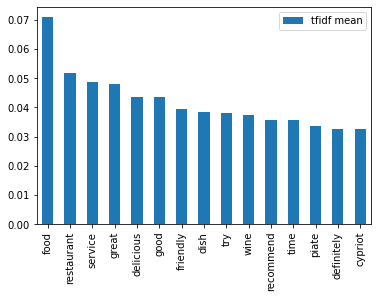

In [10]:
df_tfidf_mean[:15].plot(kind='bar')
plt.show()

### Wordcloud visualisation

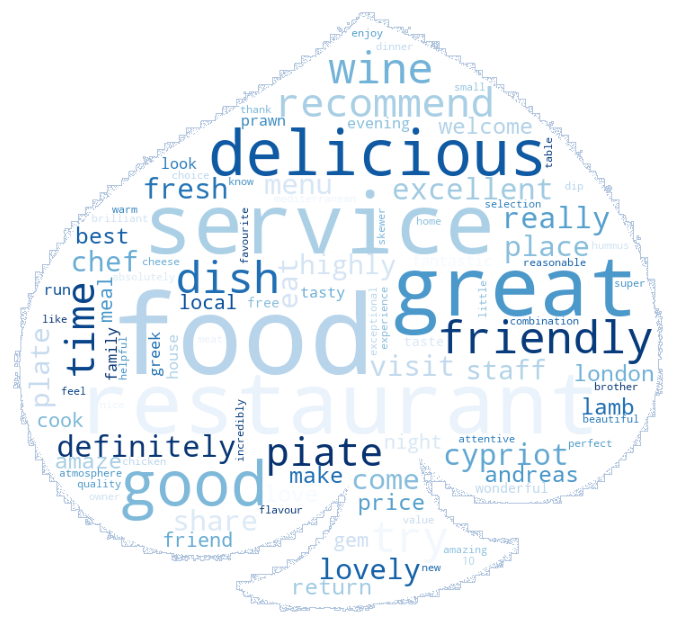

In [11]:
target_img = str(restaurant_id) + '_word_cloud.png'
target_img_path = os.path.join('..', 'cleaned_data', 'restaurant_wordclouds', target_img)
img = plt.imread(target_img_path)

plt.figure(figsize=(12,16))
plt.imshow(img)
plt.axis("off")
plt.show()

Other wordclouds and TF-IDF can be found in the dedicated folder

# Global restaurant analysis

In [12]:
# def filtering_dataframe(df, column, terms):
    
#     df = df[df[''].str.findall()]
#     return df

# def generate_wordcloud(df, idx, directory, mask):
#     #filename = directory + str(idx) + "_word_cloud.png"

#     df_mean = df.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
#     dict_words_tfidf = df_mean[df_mean['tfidf mean'] != 0].to_dict()['tfidf mean']

#     wordcloud = WordCloud(height=600, width=800, background_color="white",
#         colormap='Blues', max_words=100, mask=mask,
#         contour_width=0.5, contour_color='lightsteelblue')
#     wordcloud.generate_from_frequencies(frequencies=dict_words_tfidf)
#     wordcloud.to_file(filename)  

In [17]:
df_restaurants_cuisine.head(10)

,name,resto_TA_url,nb_reviews,min_price,max_price,keywords,address,phone_number,website,menu,ranking,rating,score,neighborhood,cuisine,food_specificity,place_type,distance_to_bokan
restaurant_id,,,,,,,,,,,,,,,,,,
1,Taste Of Peshawar,https://www.tripadvisor.co.uk/Restaurant_Revie...,171,2.0,3.0,"[Barbecue, Indian, Middle Eastern]","62 Harrow Road, Wembley HA9 6PL England",+44 20 3015 4133,Website not scraped,Menu not scraped,#1 of 155 Restaurants in Wembley,5.0,1.000,Wembley,Indian,Barbecue,None,18.049000
16,Orpington Citi Kitchen,https://www.tripadvisor.co.uk/Restaurant_Revie...,146,2.0,3.0,"[Indian, Asian, Vegan]","82 Cotmandene Crescent, Orpington, Bromley BR5...",+44 20 8302 2222,Website not scraped,Menu not scraped,#2 of 117 Restaurants in Orpington,5.0,0.991,Orpington,Indian,Vegan,None,14.096000
19,4 Locos Argentine Steakhouse,https://www.tripadvisor.co.uk/Restaurant_Revie...,139,2.0,3.0,"[Steakhouse, South American, Vegan]","6-8 Tudor Court- Russell Hill Road, Purley CR8...",+44 20 8660 5200,Website not scraped,Menu not scraped,#1 of 32 Restaurants in Purley,5.0,1.000,Purley,South American,Vegan,Steakhouse,19.149000
17,La Plata Steakhouse,https://www.tripadvisor.co.uk/Restaurant_Revie...,221,2.0,3.0,"[Steakhouse, South American, South American]","East Sheen 109 Sheen Lane, Richmond SW14 8AE E...",+44 20 8876 7747,Website not scraped,Menu not scraped,#1 of 116 Restaurants in Richmond,5.0,1.000,Richmond,South American,None,Steakhouse,17.421000
22,Madhu's Heathrow,https://www.tripadvisor.co.uk/Restaurant_Revie...,637,2.0,3.0,"[Indian, Asian, Vegan]",Bath Road Sheraton Skyline Hotel London Heathr...,+44 20 8564 3380,Website not scraped,Menu not scraped,Ranking not found,4.5,NaN,None,Indian,Vegan,None,28.702000
18,Revolution,https://www.tripadvisor.co.uk/Restaurant_Revie...,1289,2.0,3.0,"[Bar, Italian, British]","4 Whittaker Avenue Richmond, Richmond TW9 1EH ...",+44 20 8940 1379,Website not scraped,Menu not scraped,#2 of 116 Restaurants in Richmond,4.5,0.991,Richmond,Italian,None,Bar,20.242001
21,Melucci's,https://www.tripadvisor.co.uk/Restaurant_Revie...,277,2.0,3.0,"[Italian, Indian, Vegan]","55 Bexley High Street, Bexley DA5 1AB England",+44 1322 558640,Website not scraped,Menu not scraped,#1 of 36 Restaurants in Bexley,5.0,1.000,Bexley,Italian,Vegan,None,13.651000
20,Tamara Lounge,https://www.tripadvisor.co.uk/Restaurant_Revie...,684,2.0,3.0,"[Indian, Asian, Vegan]","Uxbridge Road, Uxbridge UB10 0NA England",+44 20 8848 1919,Website not scraped,Menu not scraped,#17 of 101 Restaurants in Uxbridge,3.5,1.000,Uxbridge,Indian,Vegan,None,29.143000
23,Madhu's,https://www.tripadvisor.co.uk/Restaurant_Revie...,528,2.0,3.0,"[Indian, Asian, Barbecue]","39 South Road, Southall, Ealing UB1 1SW England",+44 20 8574 1897,Website not scraped,Menu not scraped,Ranking not found,4.0,NaN,None,Indian,Barbecue,None,24.427000


In [14]:
df_restaurants_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13405 entries, 1 to 14194
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13405 non-null  object 
 1   resto_TA_url       13405 non-null  object 
 2   nb_reviews         13405 non-null  int64  
 3   min_price          10669 non-null  float64
 4   max_price          10669 non-null  float64
 5   keywords           13405 non-null  object 
 6   address            13405 non-null  object 
 7   phone_number       12554 non-null  object 
 8   website            13405 non-null  object 
 9   menu               13405 non-null  object 
 10  ranking            13405 non-null  object 
 11  rating             13405 non-null  float64
 12  score              2809 non-null   float64
 13  neighborhood       2809 non-null   object 
 14  cuisine            10237 non-null  object 
 15  food_specificity   5113 non-null   object 
 16  place_type         340

In [15]:
df_stats = cuisine_stats(df_restaurants_cuisine, stats='mean')
df_stats.head(20)

,nb_restaus,mean_nb_reviews,mean_min_price,mean_max_price,mean_rating,mean_score
cuisine,,,,,,
African,128,215.000000,1.810811,2.567568,3.878906,0.967447
American,379,295.474934,1.874598,2.614148,3.597625,0.992537
Asian,835,196.194012,1.961686,2.720307,3.905988,0.981865
British,2849,300.309231,1.919579,2.636227,4.042998,0.975848
European,528,207.589015,1.985263,2.736842,3.943182,0.984545
French,287,529.926829,2.342105,3.075188,4.137631,0.992164
Indian,1662,148.475933,1.919643,2.756868,3.812575,0.968931
International,165,195.648485,2.006757,2.770270,4.051515,0.983538
Italian,1805,221.200000,1.908010,2.703379,3.894737,0.981463


In [16]:
df_restaurants_cuisine.to_csv('cleaned_restaus.csv')

In [49]:
rooftops_path = os.path.join('..', '..', 'scraper', 'scraper_rooftops', 'scraped_data', 'merged_data', 'merged_rooftops.csv')
df_rooftops = pd.read_csv(rooftops_path, index_col=['restaurant_id'])
df_rooftops['cuisine'] = df_rooftops['cuisine'].str.replace('[', '').str.replace(']', '').str.replace("'", "")
df_rooftops['cuisine'] = df_rooftops['cuisine'].str.split(',')

In [50]:
df_rooftops.head()

,name,resto_TA_url,nb_reviews,min_price,max_price,cuisine,address,phone_number,website,menu,ranking,rating
restaurant_id,,,,,,,,,,,,
-5,Aviary,https://www.tripadvisor.co.uk/Restaurant_Revie...,465,2.0,3.0,"[European, British, Vegetarian Friendly]",Royal London House 22-29 Finsbury Square Montc...,+44 20 3873 4060,Website not scraped,Menu not scraped,"#1,570 of 16,979 Restaurants in London",4.0
-11,The Culpeper,https://www.tripadvisor.co.uk/Restaurant_Revie...,466,2.0,3.0,"[Bar, European, British]","40 Commercial Street, London E1 6LP England",+44 20 7247 5371,Website not scraped,Menu not scraped,Ranking not found,4.0
-9,Seabird,https://www.tripadvisor.co.uk/Restaurant_Revie...,101,4.0,4.0,"[Seafood, Mediterranean, Gluten Free Options]","40 Blackfriars Road The Rooftop, The Hoxton, L...",+44 20 7903 3050,Website not scraped,Menu not scraped,Ranking not found,4.0
-8,Boundary Rooftop,https://www.tripadvisor.co.uk/Restaurant_Revie...,307,2.0,3.0,"[Seafood, Mediterranean, European]",2-4 Boundary Street Entrance on Redchurch Stre...,+44 20 7729 1051,Website not scraped,Menu not scraped,Ranking not found,3.5
-10,Queen of Hoxton,https://www.tripadvisor.co.uk/Restaurant_Revie...,271,2.0,3.0,[Bar],"1 Curtain Road Hoxton, London EC2A 3JX England",+44 20 3889 8731,Website not scraped,Menu not scraped,Ranking not found,3.5


In [51]:
df_rooftops_cuisine, cuisine_rooftop_dict = cleaning_pipeline(df_rooftops, keywords_renaming_dict, parse_distances=True)


restaurant_id
-5          [European,  British,  Vegetarian Friendly]
-11                         [Bar,  European,  British]
-9     [Seafood,  Mediterranean,  Gluten Free Options]
-8                [Seafood,  Mediterranean,  European]
-10                                              [Bar]
Name: keywords, dtype: object
['European', ' British', ' Vegetarian Friendly']
<class 'list'>
['Bar', ' European', ' British']
<class 'list'>
['Seafood', ' Mediterranean', ' Gluten Free Options']
<class 'list'>
['Seafood', ' Mediterranean', ' European']
<class 'list'>
['Bar']
<class 'list'>
['Quick Bites', ' Bar']
<class 'list'>
['Bar']
<class 'list'>
['Italian', ' Mediterranean', ' European']
<class 'list'>
['European', ' British', ' Vegetarian Friendly']
<class 'list'>
['Bar', ' European']
<class 'list'>
['European', ' British']
<class 'list'>
['']
<class 'list'>
['European']
<class 'list'>
['Bar', ' British', ' Pub']
<class 'list'>
['Sushi', ' Korean', ' Fusion']
<class 'list'>
['Japanese', ' Sushi'

In [ ]:
df_rooftops_cuisine['is_rooftop'] = True

In [53]:
df_rooftops_cuisine.to_csv('cleaned_rooftops.csv')

In [61]:
df_restaurant = pd.read_csv('cleaned_restaus.csv', index_col=['restaurant_id'])

In [63]:
already_scraped_list = [10216, 13639, 12755, 14787, 14657, 10068, 13460, 13836, 12125, 9796, 11264]
to_keep = df_restaurant.index.values
to_keep = set(to_keep) - set(already_scraped_list)
df_restaurant = df_restaurant.loc[to_keep, :]

In [64]:
df_restaurant['is_rooftop'] = False
df_restaurant.to_csv('cleaned_restaus.csv')

In [65]:
all_restos = pd.concat([df_restaurant, df_rooftops_cuisine])

In [66]:
all_restos.to_csv('cleaned_all_restos.csv')